### **Credit card customer segmentation**

In [1]:
pip install -r requirements.txt


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


### IMPORT KNIHOVEN

In [2]:
# Data manipulation libraries
import pandas as pd
import numpy as np
from load_and_preview_data import load_data, preview_data

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing libraries
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from clean_unknown_data import clean_unknown_values
from data_for_classification import preprocess_for_classification
from data_for_clustering import preprocess_for_clustering


# Modeling libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import pickle

# Evaluation libraries  
from sklearn.metrics import classification_report, confusion_matrix,balanced_accuracy_score, accuracy_score

### NAČTENÍ DAT  A POPIS FEATUR

In [3]:
data = load_data('BankChurners.csv')

In [4]:
preview_data(data)


Info about the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 23 columns):
 #   Column                                                                                                                              Non-Null Count  Dtype  
---  ------                                                                                                                              --------------  -----  
 0   CLIENTNUM                                                                                                                           10127 non-null  int64  
 1   Attrition_Flag                                                                                                                      10127 non-null  object 
 2   Customer_Age                                                                                                                        10127 non-null  int64  
 3   Gender                                                  

Tento dataset poskytuje informace o zákaznících pro předpověď odchodu zákazníků u portfolia spotřebitelských kreditních karet.

- CLIENTNUM: Unikátní identifikátor pro každého zákazníka. (Celé číslo = Integer)
- Attrition_Flag: Příznak označující, zda zákazník odešel. (Boolean)
- Customer_Age: Věk zákazníka. (Celé číslo = Integer)
- Gender: Pohlaví zákazníka. (Text = String)
- Dependent_count: Počet závislých osob, které má zákazník. (Celé číslo = Integer)
- Education_Level: Úroveň vzdělání zákazníka. (String)
- Marital_Status: Rodinný stav zákazníka. (String)
- Income_Category: Příjmová kategorie zákazníka. (String)
- Card_Category: Typ karty, kterou zákazník vlastní. (String)
- Months_on_book: Jak dlouho je zákazník vedený v evidenci. (Integer)
- Total_Relationship_Count: Celkový počet vztahů, které zákazník má s poskytovatelem kreditní karty. (Integer)
- Months_Inactive_12_mon: Počet měsíců, kdy byl zákazník neaktivní za posledních dvanáct měsíců. (Integer)
- Contacts_Count_12_mon: Počet kontaktů, které měl zákazník za posledních dvanáct měsíců. (Integer)
- Credit_Limit: Úvěrový limit zákazníka. (Celé číslo)
- Total_Revolving_Bal: Celkový revolvingový zůstatek zákazníka. (Celé číslo)
- Avg_Open_To_Buy: Průměrný poměr otevřených úvěrových možností k nákupům zákazníka. (Celé číslo)
- Total_Amt_Chng_Q4_Q1: Celková změna částky od čtvrtého čtvrtletí do prvního čtvrtletí. (Celé číslo)
- Total_Trans_Amt: Celková transakční částka. (Celé číslo)
- Total_Trans_Ct: Celkový počet transakcí. (Celé číslo)
- Total_Ct_Chng_Q4_Q1: Celková změna počtu transakcí od čtvrtého čtvrtletí do prvního čtvrtletí. (Celé číslo)
- Avg_Utilization_Ratio: Průměrný poměr využití úvěrového limitu zákazníka. (Celé číslo)
- Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1: 
    Naivní Bayesův klasifikátor pro předpověď odchodu zákazníka na základě charakteristik.

### EXPLORATIVNÍ DATOVÁ ANALÝZA

Rozdělení zákazníků podle toho, zda zůstali nebo odešli.

In [5]:
# Analyza Attrition_Flag (zda zákazník odešel nebo zůstal)
churn_distribution = data['Attrition_Flag'].value_counts(normalize=True)

# zobrazení
churn_distribution


Attrition_Flag
Existing Customer    0.83934
Attrited Customer    0.16066
Name: proportion, dtype: float64

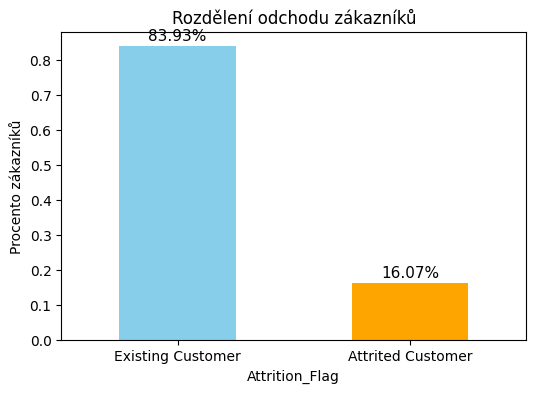

In [6]:
# Vytvoření grafu
plt.figure(figsize=(6, 4))
ax = churn_distribution.plot(kind='bar', color=['skyblue', 'orange'])

# Přidání hodnot na vrcholy sloupců
for idx, value in enumerate(churn_distribution):
    ax.text(idx, value + 0.01, f'{value * 100:.2f}%', ha='center', va='bottom', fontsize=11, color='black')

# Titul a popisky
plt.title('Rozdělení odchodu zákazníků')
plt.ylabel('Procento zákazníků')
plt.xticks(rotation=0)

# Zobrazení grafu
plt.show()

Rozdělení zákazníků ukazuje, že:

83,9 % zákazníků zůstalo s poskytovatelem kreditní karty (Existing Customer),
16,1 % zákazníků odešlo (Attrited Customer).

Rozdělení podle věku

In [7]:
# Rozdělení dat podle Attrition_Flag a rozložení věku zákazníků pro každou skupinu
analyza_veku_odchodu = data.groupby('Attrition_Flag')['Customer_Age'].describe()

# Zobrazte výsledek
analyza_veku_odchodu

,count,mean,std,min,25%,50%,75%,max
Attrition_Flag,,,,,,,,
Attrited Customer,1627.0,46.659496,7.665652,26.0,41.0,47.0,52.0,68.0
Existing Customer,8500.0,46.262118,8.081157,26.0,41.0,46.0,52.0,73.0


Průměrný věk zákazníků, kteří odešli, je 46,7 let.
Průměrný věk zákazníků, kteří zůstali, je 46,3 let.

<Figure size 600x400 with 0 Axes>

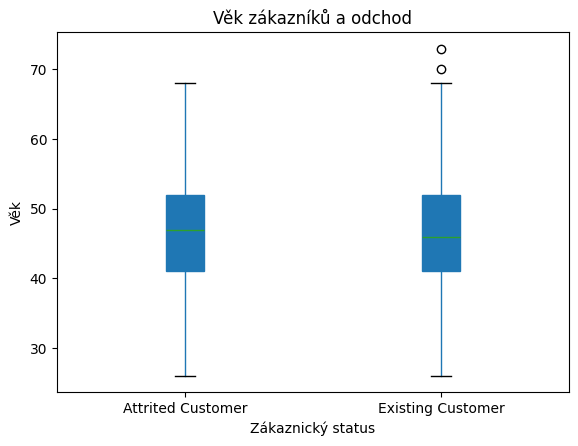

In [8]:
plt.figure(figsize=(6, 4))
data.boxplot(column='Customer_Age', by='Attrition_Flag', grid=False, patch_artist=True)
plt.title('Věk zákazníků a odchod')
plt.suptitle('')  # Suppress the automatic boxplot title
plt.xlabel('Zákaznický status')
plt.ylabel('Věk')
plt.show()


Rozdělení podle pohlaví 

In [9]:
# rozložení pohlaví (Gender) s ohledem na Attrition_Flag
gender_churn_analysis = pd.crosstab(data['Gender'], data['Attrition_Flag'], normalize='index')

# Zobrazte výsledek
gender_churn_analysis

Attrition_Flag,Attrited Customer,Existing Customer
Gender,,
F,0.173572,0.826428
M,0.146152,0.853848


17,4 % žen odešlo, zatímco 82,6 % žen zůstalo. 

14,6 % mužů odešlo, zatímco 85,4 % mužů zůstalo.

Ženy jsou o něco náchylnější k odchodu než muži

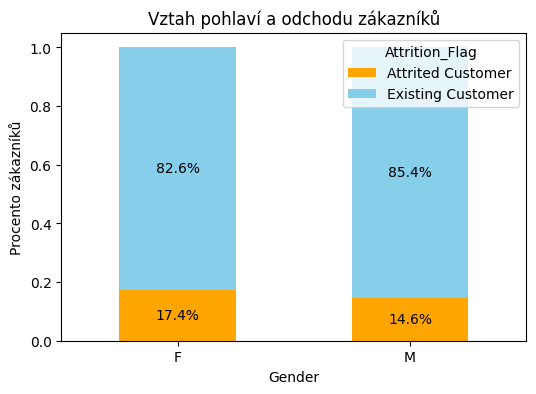

In [10]:
ax = gender_churn_analysis.plot(kind='bar', stacked=True, color=['orange', 'skyblue'], figsize=(6, 4))

# Přidání hodnot na sloupce
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    if height > 0:  # Vyhneme se nule
        ax.text(x + width / 2, y + height / 2, f'{height * 100:.1f}%', ha='center', va='center', color='black')

# Titulky a popisky
plt.title('Vztah pohlaví a odchodu zákazníků')
plt.ylabel('Procento zákazníků')
plt.xticks(rotation=0)

# Zobrazení grafu
plt.show()

Zobrazení histogramu dat

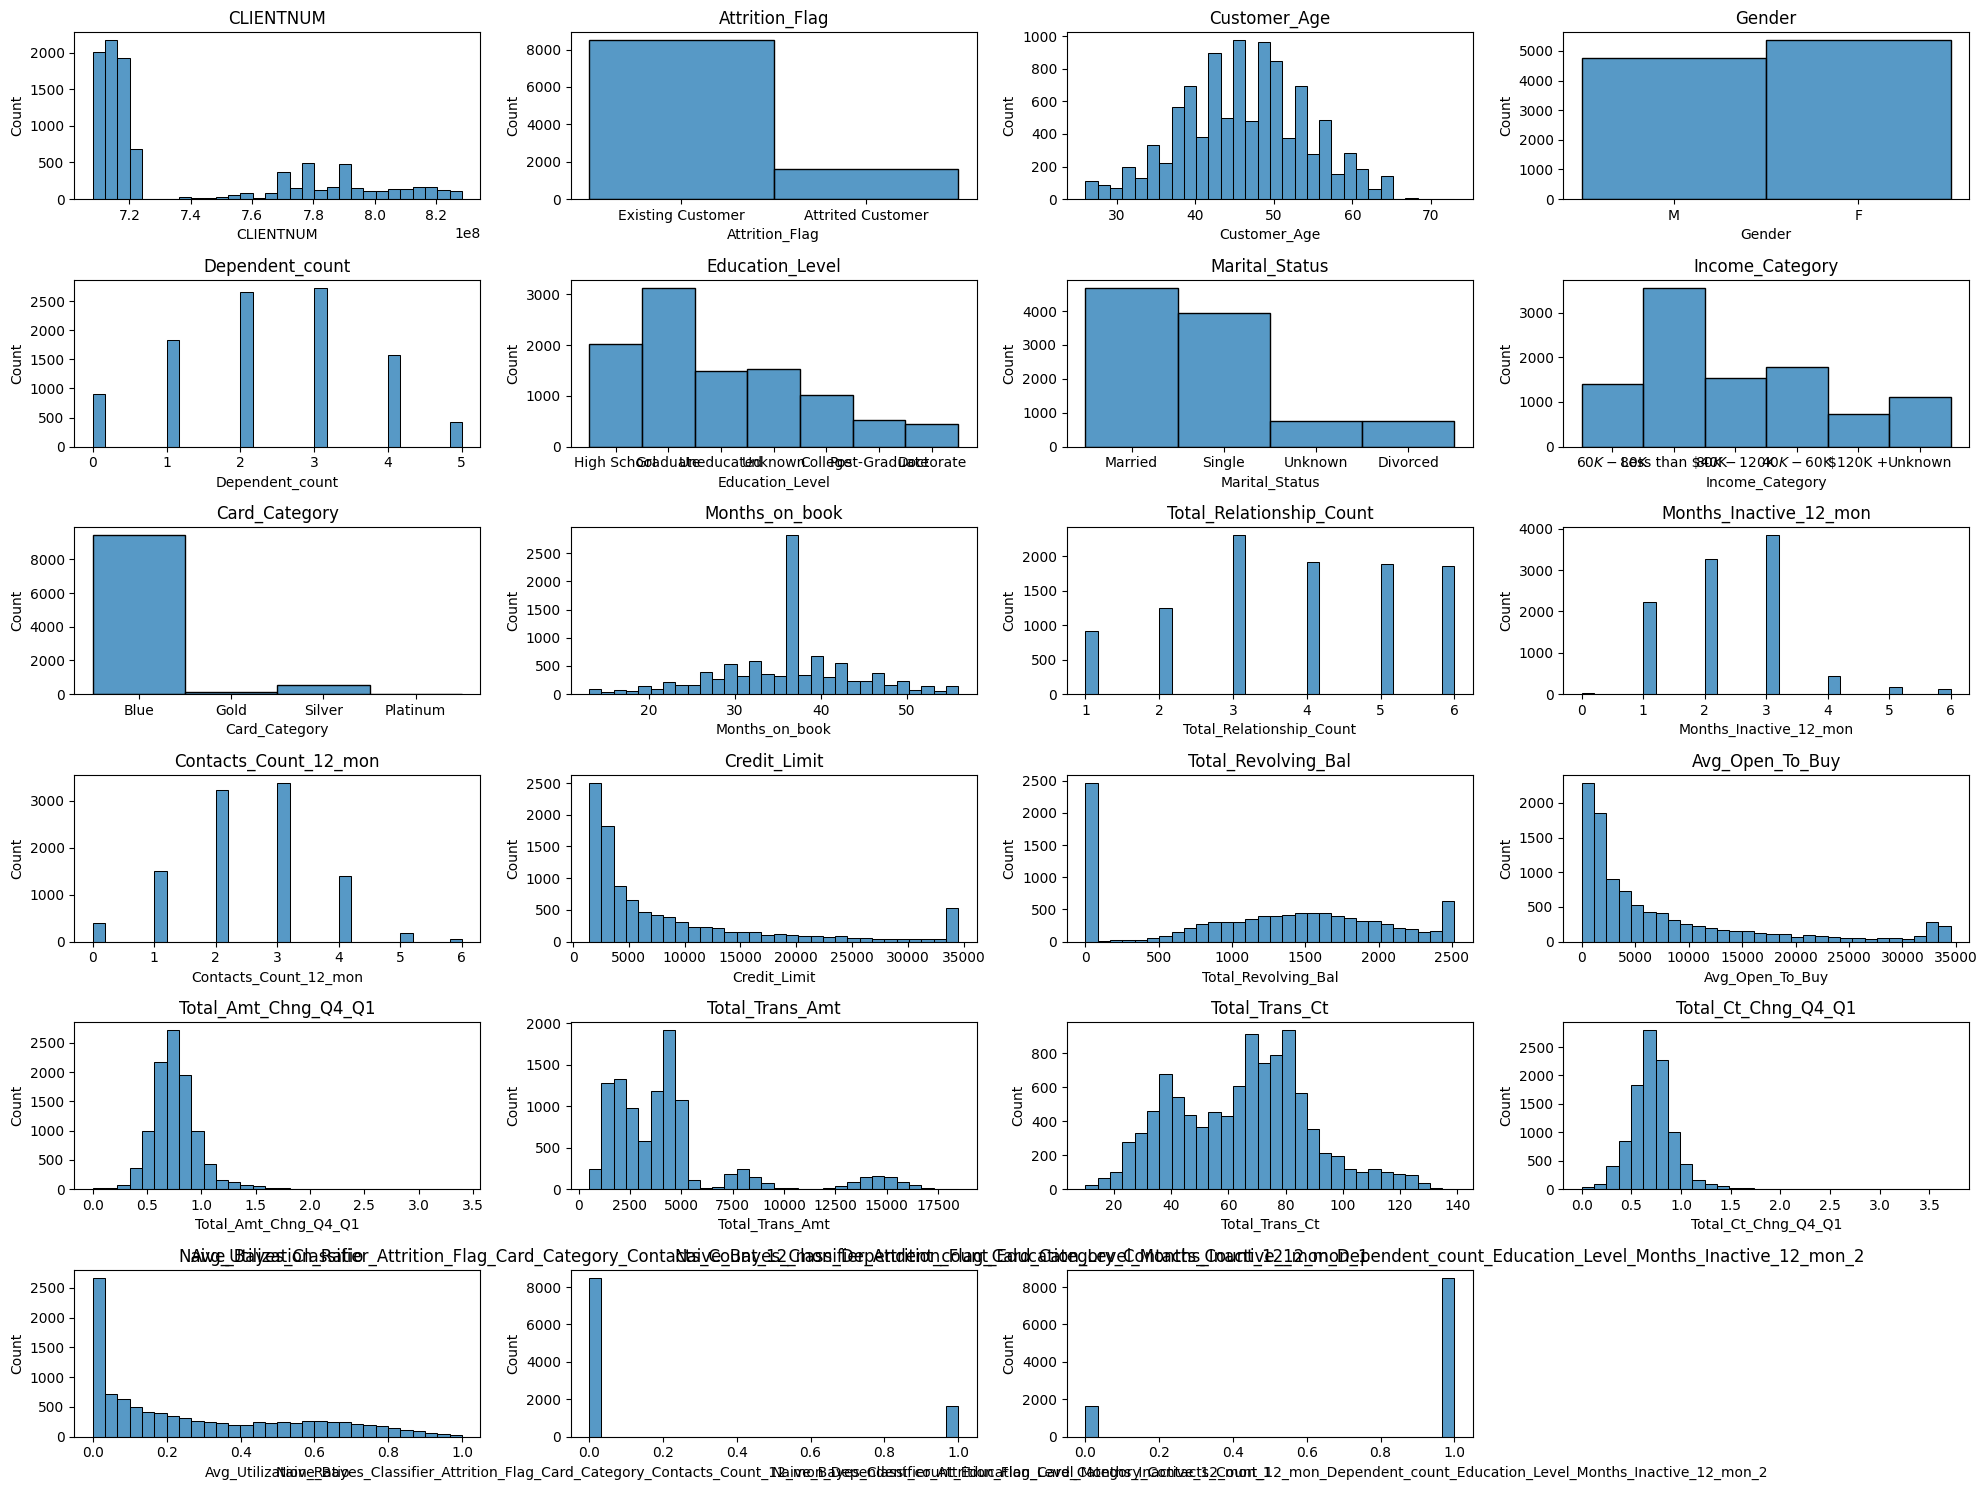

In [11]:
plt.figure(figsize=(20, 15))

# Number of features
n_features = len(data.columns)

# Plot each feature as a histogram
for i, column in enumerate(data.columns, 1):
    plt.subplot((n_features // 4) + 1, 4, i)  # Adjust the grid size based on the number of features
    sns.histplot(data[column], kde=False, bins=30)
    plt.title(column)

plt.tight_layout()
plt.show()

In [12]:
# Chybějící data - unknown
unknown_data = data.isin(['Unknown']).sum()

# zobrazení
unknown_data

CLIENTNUM                                                                                                                                0
Attrition_Flag                                                                                                                           0
Customer_Age                                                                                                                             0
Gender                                                                                                                                   0
Dependent_count                                                                                                                          0
Education_Level                                                                                                                       1519
Marital_Status                                                                                                                         749
Income_Category            

Data obsahují záznamy s hodnotou "Unknown" ve třech kategoriích:

Education_Level: 1 519 záznamů obsahuje "Unknown".
Marital_Status: 749 záznamů obsahuje "Unknown".
Income_Category: 1 112 záznamů obsahuje "Unknown".

In [13]:
# Filter for 'Unknown' in Marital_Status
unknown_marital_status = data[data['Marital_Status'] == 'Unknown']

# Filter for 'Unknown' in Income_Category
unknown_income_category = data[data['Income_Category'] == 'Unknown']

# Filter for 'Unknown' in Education_Level
unknown_education_level = data[data['Education_Level'] == 'Unknown']

In [14]:
# unknown Education_Level
unknown_education_level_summary = unknown_education_level.describe(include='all')

# zobrazení Education_Level

unknown_education_level_summary

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
count,1.519000e+03,1519,1519.000000,1519,1519.000000,1519,1519,1519,1519,1519.000000,...,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000
unique,NaN,2,NaN,2,NaN,1,4,6,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Existing Customer,NaN,F,NaN,Unknown,Married,Less than $40K,Blue,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,1263,NaN,812,NaN,1519,688,556,1420,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,7.400740e+08,NaN,46.428571,NaN,2.361422,NaN,NaN,NaN,NaN,35.859776,...,8491.798947,1160.449638,7331.349309,0.761209,4420.053325,64.745885,0.712616,0.276469,0.167869,0.832130
std,3.686304e+07,NaN,7.957479,NaN,1.330344,NaN,NaN,NaN,NaN,7.916691,...,9028.635299,816.802016,8995.376544,0.214201,3381.976884,23.142879,0.234277,0.278704,0.372564,0.372564
min,7.080833e+08,NaN,26.000000,NaN,0.000000,NaN,NaN,NaN,NaN,13.000000,...,1438.300000,0.000000,14.000000,0.061000,615.000000,10.000000,0.028000,0.000000,0.000008,0.000462
25%,7.131187e+08,NaN,41.000000,NaN,1.000000,NaN,NaN,NaN,NaN,32.000000,...,2520.500000,252.000000,1240.000000,0.629500,2207.500000,45.000000,0.578500,0.018500,0.000106,0.999640
50%,7.183575e+08,NaN,47.000000,NaN,2.000000,NaN,NaN,NaN,NaN,36.000000,...,4411.000000,1270.000000,3393.000000,0.742000,3872.000000,67.000000,0.707000,0.171000,0.000198,0.999800
75%,7.782373e+08,NaN,52.000000,NaN,3.000000,NaN,NaN,NaN,NaN,40.000000,...,10709.500000,1785.000000,9577.000000,0.862000,4685.000000,80.000000,0.821000,0.514500,0.000359,0.999890


Podrobný přehled záznamů, kde je "Unknown" ve sloupci Education_Level:

- Počet záznamů: 1 519.
- Věk: Průměrný věk zákazníků je 46,4 let (rozpětí 26 až 67 let).
- Pohlaví: 812 žen a 707 mužů.
- Dependent_count: Průměrný počet závislých osob je 2,36 (0 až 5 závislých).
- Marital_Status: Nejčastější rodinný stav je "Married" (688 záznamů).
- Income_Category: Nejčastější příjmová kategorie je "Less than $40K" (556 záznamů).
- Card_Category: Většina zákazníků vlastní kartu "Blue" (1 420 záznamů).

In [15]:
# unknown Income_Category
unknown_income_category_summary = unknown_income_category.describe(include='all')

unknown_income_category_summary

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
count,1.112000e+03,1112,1112.000000,1112,1112.000000,1112,1112,1112,1112,1112.000000,...,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000
unique,NaN,2,NaN,2,NaN,7,4,1,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Existing Customer,NaN,F,NaN,Graduate,Married,Unknown,Blue,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,925,NaN,1060,NaN,332,493,1112,1045,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,7.375797e+08,NaN,46.274281,NaN,2.275180,NaN,NaN,NaN,NaN,35.753597,...,9516.582464,1115.064748,8401.517716,0.764903,4282.211331,66.250899,0.717778,0.220810,0.167478,0.832522
std,3.658473e+07,NaN,8.663285,NaN,1.327476,NaN,NaN,NaN,NaN,8.479471,...,8677.921738,829.244551,8668.534249,0.214726,2922.695013,21.660107,0.244309,0.245436,0.372245,0.372245
min,7.080870e+08,NaN,26.000000,NaN,0.000000,NaN,NaN,NaN,NaN,13.000000,...,1438.300000,0.000000,14.000000,0.010000,644.000000,14.000000,0.000000,0.000000,0.000017,0.000420
25%,7.129088e+08,NaN,41.000000,NaN,1.000000,NaN,NaN,NaN,NaN,31.000000,...,3137.000000,0.000000,1952.250000,0.643750,2452.750000,48.000000,0.582500,0.000000,0.000097,0.999660
50%,7.173192e+08,NaN,46.000000,NaN,2.000000,NaN,NaN,NaN,NaN,36.000000,...,6380.000000,1243.000000,5464.500000,0.742000,4107.000000,69.000000,0.704000,0.125000,0.000181,0.999820
75%,7.718936e+08,NaN,52.000000,NaN,3.000000,NaN,NaN,NaN,NaN,40.000000,...,12420.250000,1785.500000,11378.250000,0.868000,4725.000000,81.000000,0.824250,0.351500,0.000341,0.999900


Podrobný přehled záznamů, kde je "Unknown" ve sloupci  Income_Category:

- Počet záznamů: 1 112.
- Věk: Průměrný věk zákazníků je 46,6 let (rozpětí 26 až 67 let).
- Pohlaví: 588 žen a 524 mužů.
- Dependent_count: Průměrný počet závislých osob je 2,47 (0 až 5 závislých).
- Education_Level: Nejčastější úroveň vzdělání je "Graduate" (407 záznamů).
- Marital_Status: Nejčastější rodinný stav je "Married" (485 záznamů).
- Card_Category: Většina zákazníků vlastní kartu "Blue" (1 020 záznamů).

In [16]:
# 'Unknown' v 'Marital_Status' 
unknown_marital_status_summary = unknown_marital_status.describe(include='all')

# Zobrazení 'Unknown' in Marital_Status
unknown_marital_status_summary

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
count,7.490000e+02,749,749.000000,749,749.000000,749,749,749,749,749.000000,...,749.000000,749.000000,749.000000,749.000000,749.00000,749.000000,749.000000,749.000000,749.000000,749.000000
unique,NaN,2,NaN,2,NaN,7,1,6,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Existing Customer,NaN,F,NaN,Graduate,Unknown,Less than $40K,Blue,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,620,NaN,380,NaN,227,749,250,683,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,7.405841e+08,NaN,45.568758,NaN,2.538051,NaN,NaN,NaN,NaN,35.189586,...,9445.283178,1157.748999,8287.534179,0.749482,4720.00534,67.146862,0.715356,0.255899,0.171446,0.828554
std,3.782986e+07,NaN,6.863617,NaN,1.265632,NaN,NaN,NaN,NaN,7.211573,...,9558.351504,825.692109,9585.015364,0.190963,3304.68602,22.531732,0.222735,0.267568,0.375728,0.375728
min,7.080951e+08,NaN,26.000000,NaN,0.000000,NaN,NaN,NaN,NaN,13.000000,...,1438.300000,0.000000,111.000000,0.018000,647.00000,15.000000,0.077000,0.000000,0.000019,0.000420
25%,7.130589e+08,NaN,42.000000,NaN,2.000000,NaN,NaN,NaN,NaN,32.000000,...,2699.000000,0.000000,1438.300000,0.640000,2494.00000,49.000000,0.582000,0.000000,0.000096,0.999660
50%,7.183887e+08,NaN,45.000000,NaN,3.000000,NaN,NaN,NaN,NaN,36.000000,...,5222.000000,1261.000000,3983.000000,0.734000,4182.00000,69.000000,0.707000,0.150000,0.000181,0.999820
75%,7.782758e+08,NaN,49.000000,NaN,3.000000,NaN,NaN,NaN,NaN,39.000000,...,12778.000000,1793.000000,11350.000000,0.856000,4887.00000,82.000000,0.815000,0.470000,0.000337,0.999900


Podrobný přehled záznamů, kde je "Unknown" ve sloupci Marital_Status:

- Počet záznamů: 749.
- Věk: Průměrný věk zákazníků je 45,6 let (rozpětí 26 až 65 let).
- Pohlaví: 380 žen a 369 mužů.
- Dependent_count: Průměrný počet závislých osob je 2,54 (0 až 5 závislých).
- Income_Category: Nejčastější příjmová kategorie je "Less than $40K" (250 záznamů).
- Education_Level: Nejčastější úroveň vzdělání je "Graduate" (227 záznamů).
- Card_Category: Většina zákazníků vlastní kartu "Blue" (683 záznamů).

### Očištění dat

In [17]:
#Předpokládejme, že lidé s vyššími příjmy budou mít vyšší education_level, nahradíme tedy hodnoty na základě příjmu a pohlaví 
#Stejným způsobem nahradíme unknown hodnoty ve sloupice income_category - na základě věku, pohlaví a education level
#Unknown hodnoty ve sloupci marital_status nahradíme - na základě věku, pohlaví a a depedent count
data_cleaned = clean_unknown_values(data)

c:\SDA\FINAL\Credit-card-attrition-analysis-in-Python\clean_unknown_data.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  income_mode_by_education_gender_age = data[data['Income_Category'] != 'Unknown'].groupby(['Education_Level', 'Gender', 'Age_Group'])['Income_Category'].agg(lambda x: x.mode()[0])
c:\SDA\FINAL\Credit-card-attrition-analysis-in-Python\clean_unknown_data.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  marital_mode_by_gender_age_dependents = data[data['Marital_Status'] != 'Unknown'].groupby(['Gender', 'Age_Group', 'Dependent_count'])['Marital_Status'].agg(lambda x: x.mode()[0])


Počet zbývajících 'Unknown' hodnot ve sloupci Education_Level: 0
Počet zbývajících 'Unknown' hodnot ve sloupci Income_Category: 0
Počet zbývajících 'Unknown' hodnot ve sloupci Marital_Status: 0


In [18]:
# kontrola unkown data
data.isin(['Unknown']).sum()

CLIENTNUM                                                                                                                             0
Attrition_Flag                                                                                                                        0
Customer_Age                                                                                                                          0
Gender                                                                                                                                0
Dependent_count                                                                                                                       0
Education_Level                                                                                                                       0
Marital_Status                                                                                                                        0
Income_Category                                 

In [19]:
#drop age group
data_cleaned = data_cleaned.drop(columns=['Age_Group','Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1','Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'], errors='ignore')
data_cleaned

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Married,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,772366833,Existing Customer,50,M,2,Graduate,Single,$40K - $60K,Blue,40,...,2,3,4003.0,1851,2152.0,0.703,15476,117,0.857,0.462
10123,710638233,Attrited Customer,41,M,2,Graduate,Divorced,$40K - $60K,Blue,25,...,2,3,4277.0,2186,2091.0,0.804,8764,69,0.683,0.511
10124,716506083,Attrited Customer,44,F,1,High School,Married,Less than $40K,Blue,36,...,3,4,5409.0,0,5409.0,0.819,10291,60,0.818,0.000
10125,717406983,Attrited Customer,30,M,2,Graduate,Married,$40K - $60K,Blue,36,...,3,3,5281.0,0,5281.0,0.535,8395,62,0.722,0.000


In [20]:
# List of features to apply get_dummies to
features_to_dummy = ["Education_Level", "Gender", "Marital_Status", "Income_Category"]

# Create dummy variables for the specified features
final_data = pd.get_dummies(data_cleaned, columns=features_to_dummy, drop_first=True)

SHLUKOVÁNÍ

In [21]:
clustering_data = preprocess_for_clustering(data_cleaned)

In [1]:
import pandas as pd
data= pd.read_csv("C:/Users/Asus/Desktop/Projekt SDA/BankChurners.csv")
print(data.head())

   CLIENTNUM     Attrition_Flag  Customer_Age Gender  Dependent_count  \
0  768805383  Existing Customer            45      M                3   
1  818770008  Existing Customer            49      F                5   
2  713982108  Existing Customer            51      M                3   
3  769911858  Existing Customer            40      F                4   
4  709106358  Existing Customer            40      M                3   

  Education_Level Marital_Status Income_Category Card_Category  \
0     High School        Married     $60K - $80K          Blue   
1        Graduate         Single  Less than $40K          Blue   
2        Graduate        Married    $80K - $120K          Blue   
3     High School        Unknown  Less than $40K          Blue   
4      Uneducated        Married     $60K - $80K          Blue   

   Months_on_book  ...  Credit_Limit  Total_Revolving_Bal  Avg_Open_To_Buy  \
0              39  ...       12691.0                  777          11914.0   
1       

In [2]:
from clean_unknown_data import clean_unknown_values
data_cleaned = clean_unknown_values(data)

Počet zbývajících 'Unknown' hodnot ve sloupci Education_Level: 0
Počet zbývajících 'Unknown' hodnot ve sloupci Income_Category: 0
Počet zbývajících 'Unknown' hodnot ve sloupci Marital_Status: 0


In [5]:
from data_for_clustering import preprocess_for_clustering
# Načtení dat
data = pd.read_csv("C:/Users/Asus/Desktop/Projekt SDA/BankChurners.csv")

# Předzpracování dat
processed_data, scaler = preprocess_for_clustering(data)

# Zobrazení prvních pěti řádků
print(processed_data.head())

   Customer_Age  Dependent_count  Months_on_book  Total_Relationship_Count  \
0     -0.165406         0.503368        0.384621                  0.763943   
1      0.333570         2.043199        1.010715                  1.407306   
2      0.583058         0.503368        0.008965                  0.120579   
3     -0.789126         1.273283       -0.241473                 -0.522785   
4     -0.789126         0.503368       -1.869317                  0.763943   

   Months_Inactive_12_mon  Contacts_Count_12_mon  Credit_Limit  \
0               -1.327136               0.492404      0.446622   
1               -1.327136              -0.411616     -0.041367   
2               -1.327136              -2.219655     -0.573698   
3                1.641478              -1.315636     -0.585251   
4               -1.327136              -2.219655     -0.430877   

   Total_Revolving_Bal  Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  ...  \
0            -0.473422         0.488971              2.623494  .

c:\Users\Asus\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Asus\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Asus\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Asus\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kme

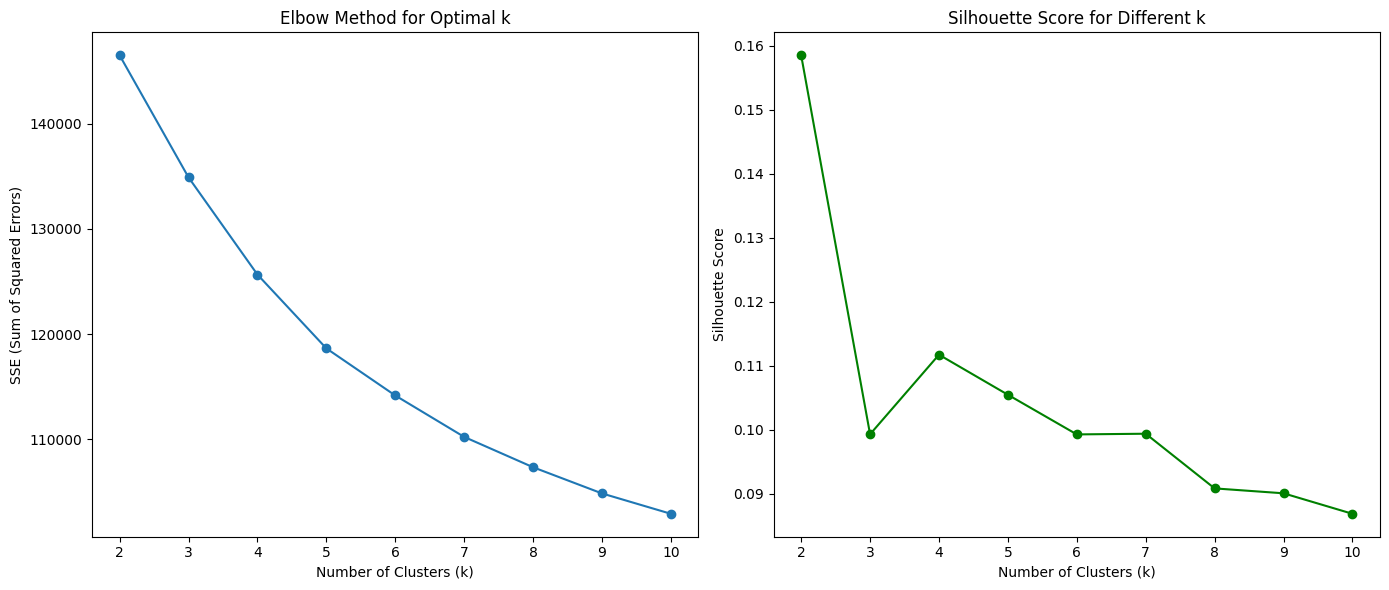

In [6]:
from clustering_analysis import elbow_and_silhouette

# Příklad použití:
elbow_and_silhouette(processed_data, max_clusters=10)

In [7]:
from silhouette_analysis import calculate_silhouette_score

# Příklad použití pro 4 shluky
silhouette_score_4_clusters = calculate_silhouette_score(processed_data, n_clusters=4)

c:\Users\Asus\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Pro 4 shluků je průměrné Silhouette Score: 0.11171806227626478


c:\Users\Asus\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


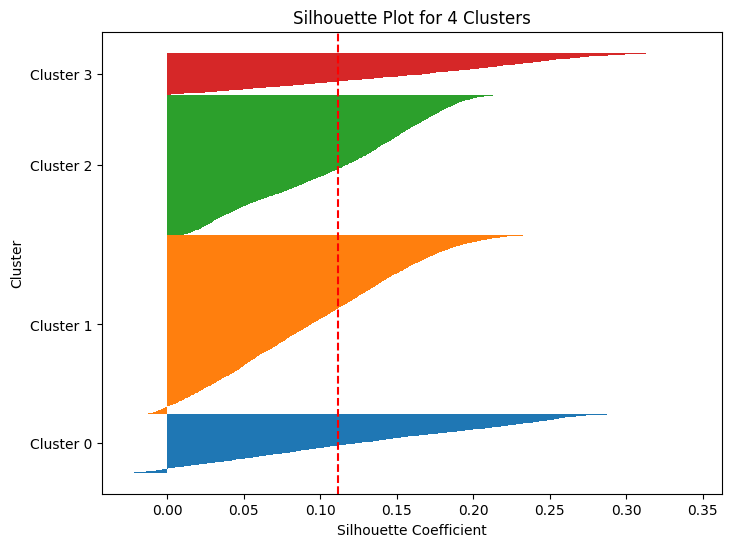

In [8]:
from silhouette_visualization import visualize_silhouette

# Příklad použití pro 4 shluky
visualize_silhouette(processed_data, n_clusters=4)

c:\Users\Asus\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


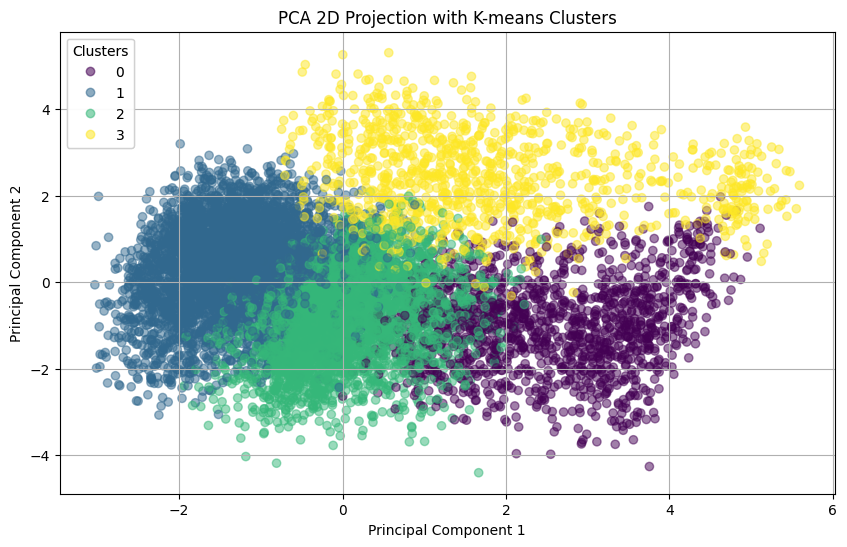

In [9]:
from pca_kmeans_visualization import visualize_pca_kmeans

# Příklad použití pro 4 shluky
visualize_pca_kmeans(processed_data, n_clusters=4)

c:\Users\Asus\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


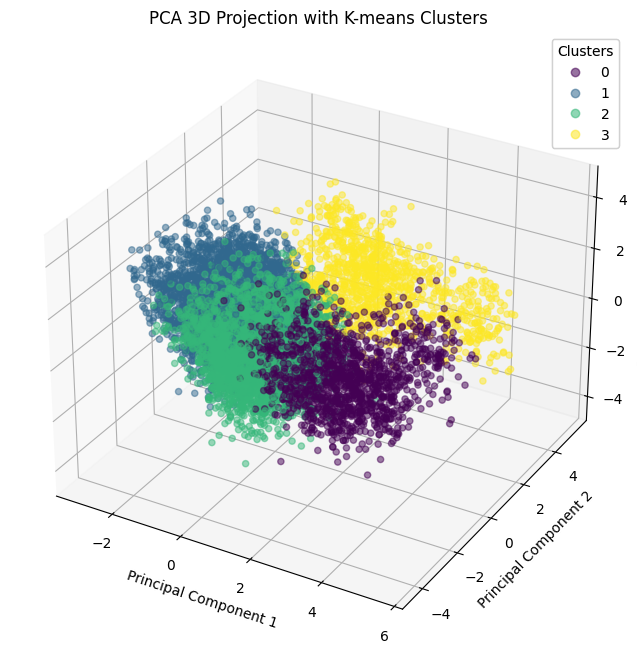

In [10]:
from pca_kmeans_visualization_3d import visualize_pca_kmeans_3d

# Příklad použití funkce s daty processed_data a 4 shluky
visualize_pca_kmeans_3d(processed_data, n_clusters=4)

In [16]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters=4, random_state=42)
model.fit(processed_data)  # Tady musíš natrénovat model
data_cleaned['Cluster'] = model.labels_  # A pak přiřadit labely shluků
cluster_labels = model.labels_

c:\Users\Asus\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [17]:
from calculate_cluster_attrition import calculate_cluster_attrition
result = calculate_cluster_attrition(data_cleaned)

   Cluster  Odešli  Zůstali  Celkem
0        0     218     1200    1418
1        1     346     3966    4312
2        2    1036     2339    3375
3        3      27      995    1022


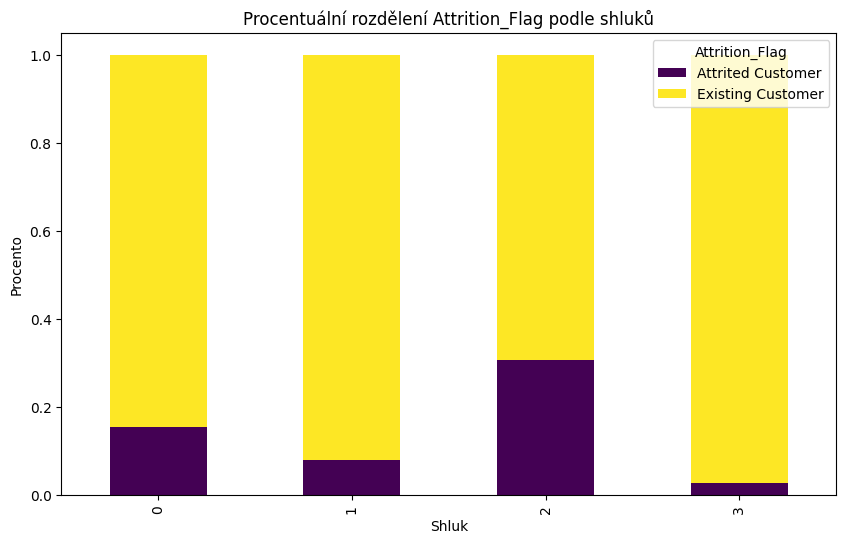

In [18]:
from plot_attrition_distribution import plot_attrition_distribution
result = plot_attrition_distribution(data_cleaned)

In [19]:
from cluster_analysis import analyze_clusters
analyze_clusters(data_cleaned, cluster_labels)

   CLIENTNUM     Attrition_Flag  Customer_Age Gender  Dependent_count  \
0  768805383  Existing Customer            45      M                3   
1  818770008  Existing Customer            49      F                5   
2  713982108  Existing Customer            51      M                3   
3  769911858  Existing Customer            40      F                4   
4  709106358  Existing Customer            40      M                3   

  Education_Level Marital_Status Income_Category Card_Category  \
0     High School        Married     $60K - $80K          Blue   
1        Graduate         Single  Less than $40K          Blue   
2        Graduate        Married    $80K - $120K          Blue   
3     High School        Married  Less than $40K          Blue   
4      Uneducated        Married     $60K - $80K          Blue   

   Months_on_book  ...  Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  \
0              39  ...          11914.0                 1.335   
1              44  ...           7

,CLIENTNUM,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2,Cluster,Attrited Customer,Existing Customer
Cluster,,,,,,,,,,,,,,,,,,,,
0,7.403963e+08,46.534556,2.547955,36.133286,3.951340,2.304654,2.535261,26205.546544,1206.786319,24998.760226,0.770721,3596.688293,59.421721,0.717101,0.050665,0.153116,0.846884,0.0,0.153738,0.846262
1,7.393865e+08,46.364564,2.307978,35.850417,4.099722,2.298237,2.359462,3847.567695,1682.850186,2164.717509,0.789212,3518.119666,62.491187,0.756387,0.534958,0.079992,0.920009,1.0,0.080241,0.919759
2,7.389975e+08,46.490963,2.310815,36.179259,3.885037,2.449481,2.627556,5954.269689,406.817185,5547.452504,0.713435,3294.981630,57.973037,0.648551,0.065391,0.305562,0.694438,2.0,0.306963,0.693037
3,7.372000e+08,45.328767,2.344423,35.144814,2.169276,2.215264,2.180039,13277.845401,1404.243640,11873.601761,0.775062,12925.032290,105.130137,0.729384,0.180597,0.026401,0.973600,3.0,0.026419,0.973581


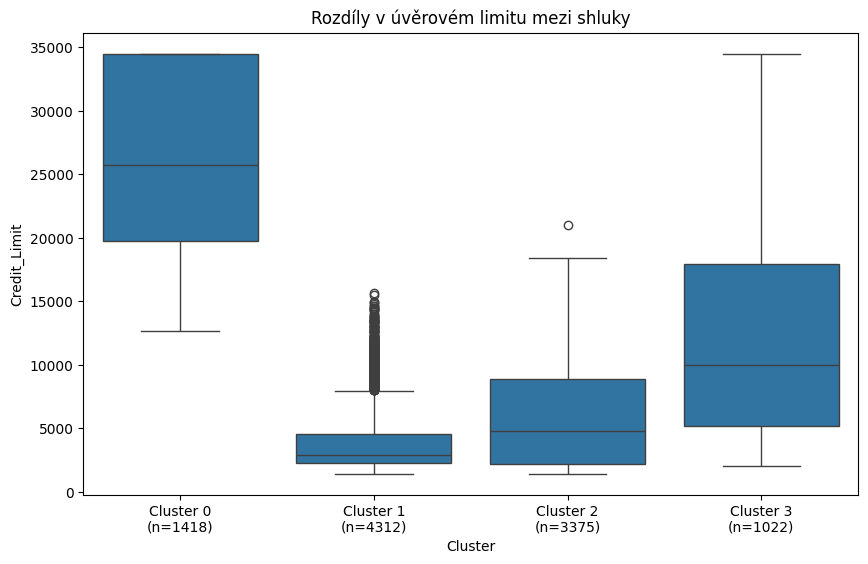

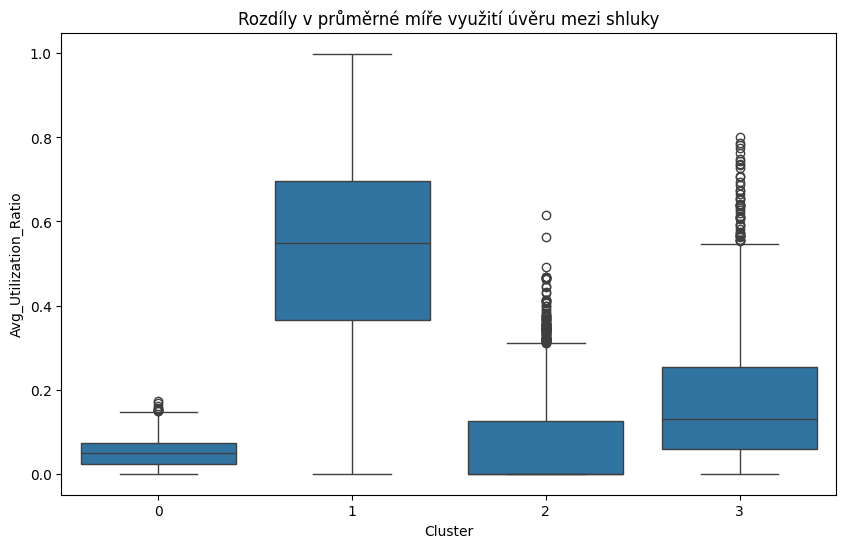

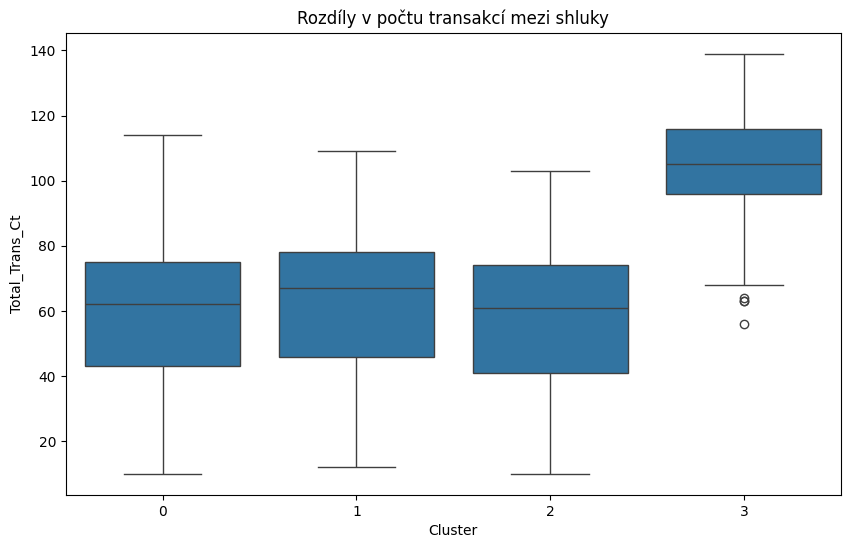

In [20]:
# Porovnání jednotlivých shluků. 

from plot_cluster_analysis import plot_cluster_analysis

# Volání funkce s připravenými daty
plot_cluster_analysis(data_cleaned)

In [27]:
# Předpokládáme, že máš již dataset 'data_cleaned' s přiřazenými shluky (Cluster)
second_cluster = data_cleaned[data_cleaned['Cluster'] == 2]  # Vybíráme data, která jsou ve shluku 2

# Podíváme se na popisnou statistiku ve druhém shluku
second_cluster_stats = second_cluster.describe()

# Zobrazení popisné statistiky
print(second_cluster_stats)

# Podívám se na popisnou statistiku ve druhém shluku
second_cluster_stats = second_cluster.describe()

# Zobrazení statistiky v tabulce
import pandas as pd

# Tato funkce zobrazí tabulku ve formátu
second_cluster_stats


          CLIENTNUM  Customer_Age  Dependent_count  Months_on_book  \
count  3.375000e+03   3375.000000      3375.000000     3375.000000   
mean   7.389975e+08     46.490963         2.310815       36.179259   
std    3.686024e+07      8.088197         1.290951        7.995786   
min    7.080846e+08     26.000000         0.000000       13.000000   
25%    7.130303e+08     41.000000         1.000000       32.000000   
50%    7.176401e+08     46.000000         2.000000       36.000000   
75%    7.726099e+08     52.000000         3.000000       41.000000   
max    8.282919e+08     66.000000         5.000000       56.000000   

       Total_Relationship_Count  Months_Inactive_12_mon  \
count               3375.000000             3375.000000   
mean                   3.885037                2.449481   
std                    1.478095                1.023021   
min                    1.000000                0.000000   
25%                    3.000000                2.000000   
50%            

,CLIENTNUM,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2,Cluster
count,3.375000e+03,3375.000000,3375.000000,3375.000000,3375.000000,3375.000000,3375.000000,3375.000000,3375.000000,3375.000000,3375.000000,3375.000000,3375.000000,3375.000000,3375.000000,3375.000000,3375.000000,3375.0
mean,7.389975e+08,46.490963,2.310815,36.179259,3.885037,2.449481,2.627556,5954.269689,406.817185,5547.452504,0.713435,3294.981630,57.973037,0.648551,0.065391,0.305562,0.694438,2.0
std,3.686024e+07,8.088197,1.290951,7.995786,1.478095,1.023021,1.118211,4178.165599,563.220280,3985.950643,0.193334,1604.476027,19.636581,0.216000,0.097000,0.458899,0.458899,0.0
min,7.080846e+08,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,552.300000,0.000000,510.000000,10.000000,0.000000,0.000000,0.000008,0.000420,2.0
25%,7.130303e+08,41.000000,1.000000,32.000000,3.000000,2.000000,2.000000,2220.000000,0.000000,2047.500000,0.588000,2013.500000,41.000000,0.508500,0.000000,0.000115,0.007360,2.0
50%,7.176401e+08,46.000000,2.000000,36.000000,4.000000,2.000000,3.000000,4784.000000,0.000000,4396.000000,0.705000,3170.000000,61.000000,0.647000,0.000000,0.000260,0.999740,2.0
75%,7.726099e+08,52.000000,3.000000,41.000000,5.000000,3.000000,3.000000,8869.000000,853.500000,8133.000000,0.827000,4409.000000,74.000000,0.778000,0.124500,0.992640,0.999890,2.0
max,8.282919e+08,66.000000,5.000000,56.000000,6.000000,6.000000,6.000000,20974.000000,2517.000000,20974.000000,1.893000,10583.000000,103.000000,2.500000,0.616000,0.999580,0.999990,2.0


In [28]:
# Zobrazím si věk, pohlaví  a kotegorii příjmů zákazníků ve druhém shluku.
second_cluster[['Customer_Age', 'Gender', 'Income_Category']].value_counts()

Customer_Age  Gender  Income_Category
44            F       Less than $40K     83
47            F       Less than $40K     80
49            F       Less than $40K     77
46            F       Less than $40K     77
48            F       Less than $40K     75
                                         ..
34            M       $60K - $80K         1
51            M       Less than $40K      1
33            M       $120K +             1
60            M       $80K - $120K        1
66            F       Less than $40K      1
Name: count, Length: 245, dtype: int64

In [36]:
from second_cluster_data import display_second_cluster_data
display_second_cluster_data()

   Customer_Age Gender Income_Category  Count
0            45      F  Less than $40K    125
1            44      F  Less than $40K    115
2            43      F  Less than $40K    108
3            50      F  Less than $40K    106
4            49      F  Less than $40K    104
5            60      M         $120K +      1
6            52      M  Less than $40K      1
7            32      M         $120K +      1
8            35      M  Less than $40K      1
9            73      M     $40K - $60K      1


Index(['Customer_Age', 'Gender', 'Income_Category', 'Count'], dtype='object')


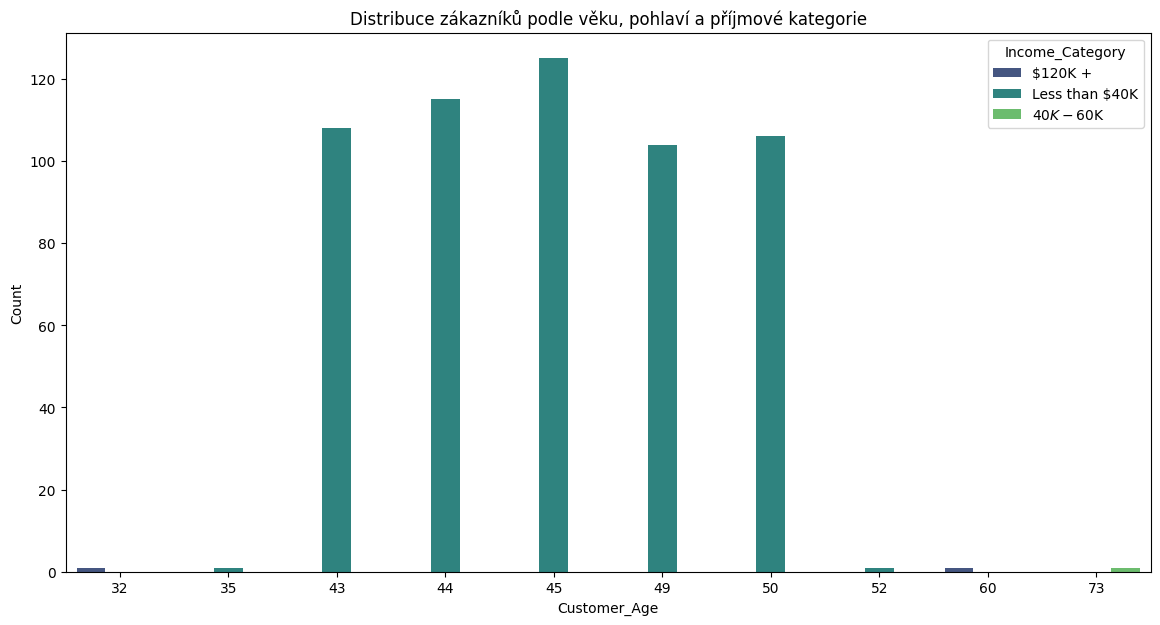

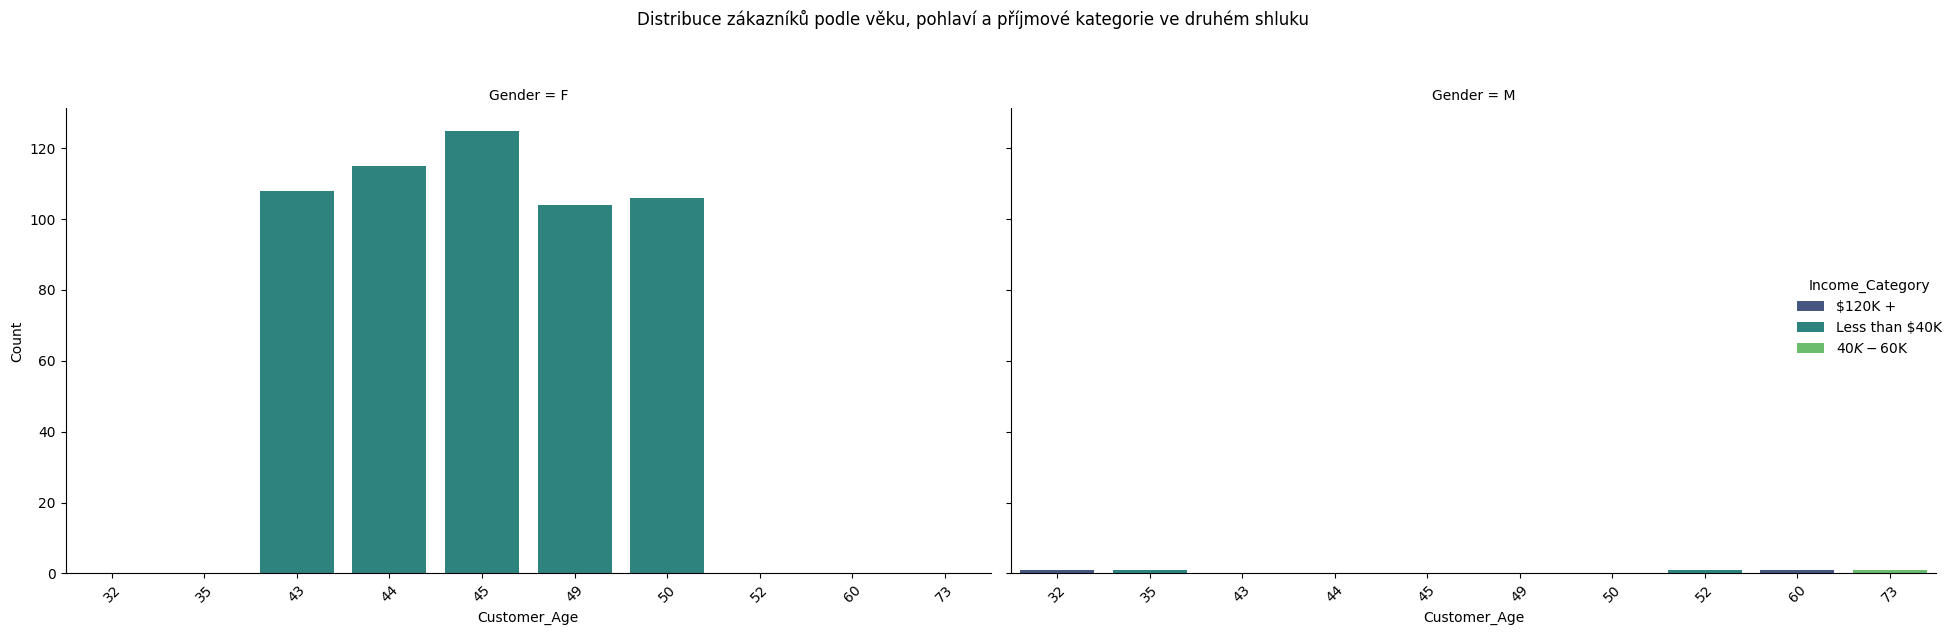

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Původní data ve formátu Series
data_second_cluster = pd.Series({
    (45, 'F', 'Less than $40K'): 125,
    (44, 'F', 'Less than $40K'): 115,
    (43, 'F', 'Less than $40K'): 108,
    (50, 'F', 'Less than $40K'): 106,
    (49, 'F', 'Less than $40K'): 104,
    (60, 'M', '$120K +'): 1,
    (52, 'M', 'Less than $40K'): 1,
    (32, 'M', '$120K +'): 1,
    (35, 'M', 'Less than $40K'): 1,
    (73, 'M', '$40K - $60K'): 1
}).reset_index(name='count')

# Přidáme názvy sloupců pro lepší interpretaci dat
data_second_cluster.columns = ['Customer_Age', 'Gender', 'Income_Category', 'Count']

# Zkontroluj, zda nyní sloupce vypadají správně
print(data_second_cluster.columns)

# Vytvoříme barplot se zohledněním věku, pohlaví a příjmové kategorie
plt.figure(figsize=(14, 7))
sns.barplot(x='Customer_Age', y='Count', hue='Income_Category', data=data_second_cluster, palette='viridis', dodge=True)
plt.title('Distribuce zákazníků podle věku, pohlaví a příjmové kategorie')
plt.show()


# Rozdělení sloupců podle pohlaví
g = sns.catplot(x='Customer_Age', y='Count', hue='Income_Category', col='Gender', data=data_second_cluster, kind='bar', height=6, aspect=1.5, palette='viridis')

# Nastavení grafu
g.set_xticklabels(rotation=45)
g.fig.suptitle('Distribuce zákazníků podle věku, pohlaví a příjmové kategorie ve druhém shluku', y=1.05)
plt.tight_layout()

In [39]:
avg_counts_by_gender_age_income = data_second_cluster.groupby(['Gender', 'Customer_Age', 'Income_Category'])['Count'].mean()
print(avg_counts_by_gender_age_income)

Gender  Customer_Age  Income_Category
F       43            Less than $40K     108.0
        44            Less than $40K     115.0
        45            Less than $40K     125.0
        49            Less than $40K     104.0
        50            Less than $40K     106.0
M       32            $120K +              1.0
        35            Less than $40K       1.0
        52            Less than $40K       1.0
        60            $120K +              1.0
        73            $40K - $60K          1.0
Name: Count, dtype: float64


KLASIFIKACE

In [22]:
classification_data = preprocess_for_classification(final_data)
classification_data

(       Attrition_Flag  Customer_Age  Dependent_count  Card_Category  \
 0                   1     -0.165406         0.503368              0   
 1                   1      0.333570         2.043199              0   
 2                   1      0.583058         0.503368              0   
 3                   1     -0.789126         1.273283              0   
 4                   1     -0.789126         0.503368              0   
 ...               ...           ...              ...            ...   
 10122               1      0.458314        -0.266547              0   
 10123               0     -0.664382        -0.266547              0   
 10124               0     -0.290150        -1.036462              0   
 10125               0     -2.036565        -0.266547              0   
 10126               0     -0.414894        -0.266547              3   
 
        Months_on_book  Total_Relationship_Count  Months_Inactive_12_mon  \
 0            0.384621                  0.763943          

In [23]:

data_for_correlation = classification_data[0]

# Výpočet korelační matice
corr = data_for_correlation.corr()

# Zobrazení korelační matice s barevným přechodem
corr.style.background_gradient(cmap='coolwarm')

,Attrition_Flag,Customer_Age,Dependent_count,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Education_Level_Doctorate,Education_Level_Graduate,Education_Level_High School,Education_Level_Post-Graduate,Education_Level_Uneducated,Gender_M,Marital_Status_Married,Marital_Status_Single,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K
Attrition_Flag,1.000000,-0.018203,-0.018991,0.006038,-0.013687,0.150005,-0.152449,-0.204491,0.023873,0.263053,0.000285,0.131063,0.168598,0.371403,0.290054,0.178410,-0.029386,0.001935,0.011730,-0.011127,0.001444,0.037272,0.021449,-0.021427,0.012641,0.028259,0.004379,-0.027538
Customer_Age,-0.018203,1.000000,-0.122254,-0.020131,0.788912,-0.010931,0.054361,-0.018452,0.002476,0.014780,0.001151,-0.062042,-0.046446,-0.067097,-0.012143,0.007114,0.025199,0.003665,0.001199,-0.022081,0.005057,-0.017312,0.043421,-0.021517,-0.014753,-0.019479,0.003528,-0.000655
Dependent_count,-0.018991,-0.122254,1.000000,0.021674,-0.103062,-0.039076,-0.010768,-0.040505,0.068065,-0.002688,0.068291,-0.035439,0.025046,0.049912,0.011087,-0.037135,-0.003368,0.004149,-0.013127,0.009459,0.002190,0.004563,0.046918,-0.051444,-0.019447,0.027723,0.045777,-0.050256
Card_Category,0.006038,-0.020131,0.021674,1.000000,-0.014749,-0.073770,-0.016816,-0.000919,0.484090,0.017027,0.482462,0.004061,0.176377,0.116579,-0.004541,-0.205089,-0.004212,0.008405,-0.014271,0.009211,-0.001766,0.079203,-0.042664,0.040467,-0.003935,0.030730,0.039770,-0.068584
Months_on_book,-0.013687,0.788912,-0.103062,-0.014749,1.000000,-0.009203,0.074164,-0.010774,0.007507,0.008623,0.006732,-0.048959,-0.038591,-0.049819,-0.014072,-0.007541,0.024114,0.000687,0.002637,-0.016703,0.001099,-0.006728,0.027783,-0.013549,-0.004710,-0.017618,0.005424,-0.005436
Total_Relationship_Count,0.150005,-0.010931,-0.039076,-0.073770,-0.009203,1.000000,-0.003675,0.055203,-0.071386,0.013726,-0.072601,0.050119,-0.347229,-0.241891,0.040831,0.067663,-0.009077,0.002160,-0.001707,0.012050,0.008202,0.003157,0.012625,-0.017838,-0.006923,0.005337,0.000938,0.004089
Months_Inactive_12_mon,-0.152449,0.054361,-0.010768,-0.016816,0.074164,-0.003675,1.000000,0.029493,-0.020394,-0.042210,-0.016605,-0.032247,-0.036982,-0.042787,-0.038989,-0.007503,0.002432,-0.003413,-0.005575,-0.006240,0.010127,-0.011163,-0.010174,0.009419,-0.020121,-0.004716,-0.006099,0.024517
Contacts_Count_12_mon,-0.204491,-0.018452,-0.040505,-0.000919,-0.010774,0.055203,0.029493,1.000000,0.020817,-0.053913,0.025646,-0.024445,-0.112774,-0.152213,-0.094997,-0.055471,-0.001016,0.003070,-0.003927,-0.006878,0.012596,0.039987,-0.003325,0.007876,0.003534,0.001150,0.011585,-0.022631
Credit_Limit,0.023873,0.002476,0.068065,0.484090,0.007507,-0.071386,-0.020394,0.020817,1.000000,0.042493,0.995981,0.012813,0.171730,0.075927,-0.002020,-0.482965,-0.005195,-0.009133,-0.001432,0.005879,0.012213,0.420806,-0.041560,0.030328,-0.160267,0.095129,0.335538,-0.361134
Total_Revolving_Bal,0.263053,0.014780,-0.002688,0.017027,0.008623,0.013726,-0.042210,-0.053913,0.042493,1.000000,-0.047167,0.058174,0.064370,0.056060,0.089861,0.624022,-0.018208,-0.001203,0.019276,0.007068,-0.004446,0.029658,0.036749,-0.036224,0.005440,-0.004048,0.022931,-0.028433


In [24]:
treshold = 0.1
target_col = "Attrition_Flag"
data_corr_reduced = data_for_correlation.iloc[:, list(abs(corr.loc[target_col]) > treshold)]

data_corr_reduced

,Attrition_Flag,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,1,0.763943,-1.327136,0.492404,-0.473422,2.623494,-0.959707,-0.973895,3.834003,-0.775882
1,1,1.407306,-1.327136,-0.411616,-0.366667,3.563293,-0.916433,-1.357340,12.608573,-0.616276
2,1,0.120579,-1.327136,-2.219655,-1.426858,8.367214,-0.740982,-1.911206,6.807864,-0.997155
3,1,-0.522785,1.641478,-1.315636,1.661686,2.942843,-0.951758,-1.911206,6.807864,1.759686
4,1,0.763943,-1.327136,-2.219655,-1.426858,6.455682,-1.056263,-1.570365,7.509325,-0.997155
...,...,...,...,...,...,...,...,...,...,...
10122,1,-0.522785,-0.337598,0.492404,0.844455,-0.259771,3.259358,2.221481,0.608119,0.678714
10123,0,0.120579,-0.337598,0.492404,1.255524,0.201004,1.283475,0.176440,-0.122745,0.856458
10124,0,0.763943,0.651940,1.396424,-1.426858,0.269436,1.732994,-0.207005,0.444305,-0.997155
10125,0,0.120579,0.651940,0.492404,-1.426858,-1.026208,1.174848,-0.121795,0.041070,-0.997155


In [25]:
# rozdělení na featury a cílovou proměnnou
y = data_corr_reduced[target_col]
X = data_corr_reduced.drop(columns = target_col)

In [26]:
# rozdělení trénovací a testovací data se stratify -> po třídách
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(8101, 9) (8101,)
(2026, 9) (2026,)


In [27]:
# definice hyperparametrů pro grid search optimalizaci
hpp = {"n_neighbors": [3, 5, 7, 1001], "weights": ["distance", "uniform"], "metric": ["euclidean", "manhattan"]}

In [28]:
# inicializace konkrétního modelu
knn = KNeighborsClassifier()

In [29]:
# inicializace grid search -> model, parametry, scoring a výpis
gs = GridSearchCV(knn, hpp, scoring="balanced_accuracy", verbose=3)

In [30]:
# spustit optimalizaci -> vyzkoušet kombinace parametrů pro daný model
gs.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END metric=euclidean, n_neighbors=3, weights=distance;, score=0.828 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=3, weights=distance;, score=0.832 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=3, weights=distance;, score=0.833 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=3, weights=distance;, score=0.805 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=3, weights=distance;, score=0.833 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.828 total time=   0.1s
[CV 2/5] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.830 total time=   0.1s
[CV 3/5] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.836 total time=   0.1s
[CV 4/5] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.803 total time=   0.1s
[CV 5/5] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.835 tot

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [3, 5, 7, 1001],
                         'weights': ['distance', 'uniform']},
             scoring='balanced_accuracy', verbose=3)

In [31]:
# parametry nejlepšího modelu
gs.best_params_
# načtení nejlepšího modelu
best_model = gs.best_estimator_

In [32]:
# aplikace nejlepšího modelu na testovací data
best_model_pred = best_model.predict(X_test)

In [33]:
# metriky nejlepšího modelu na testovacích datech
print(classification_report(best_model_pred, y_test))

              precision    recall  f1-score   support

           0       0.74      0.85      0.79       283
           1       0.98      0.95      0.96      1743

    accuracy                           0.94      2026
   macro avg       0.86      0.90      0.88      2026
weighted avg       0.94      0.94      0.94      2026



In [34]:
balanced_accuracy_score(best_model_pred, y_test)

0.9016986674613648

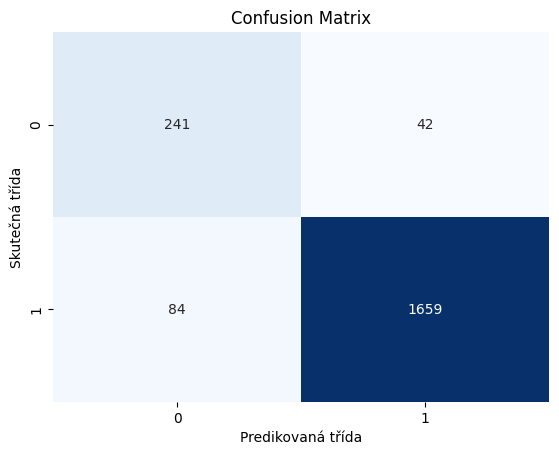

In [35]:
# Výpočet confusion matrix
cm = confusion_matrix(best_model_pred, y_test)

# Vizualizace pomocí heatmapy v Seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('Skutečná třída')
plt.xlabel('Predikovaná třída')
plt.show()

 Random Forest


In [36]:
y = data_corr_reduced[target_col]
X = data_corr_reduced.drop(columns = target_col)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

accuracy, conf_matrix

(0.9619940769990128,
 array([[ 277,   50],
        [  27, 1672]], dtype=int64))

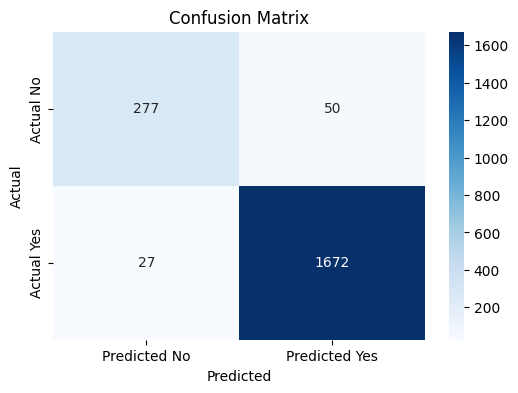

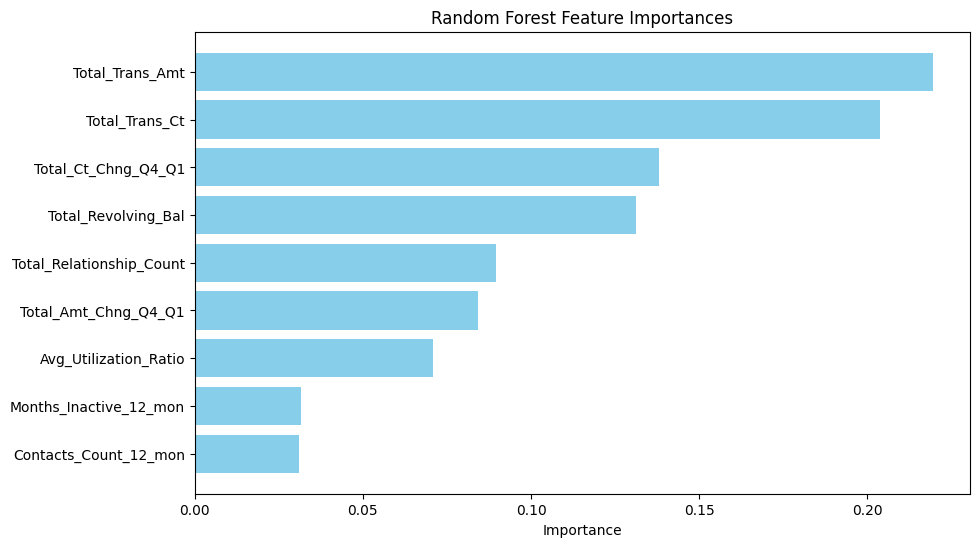

In [37]:
# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted No', 'Predicted Yes'], yticklabels=['Actual No', 'Actual Yes'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Plot feature importance
feature_importances = rf_model.feature_importances_
sorted_idx = feature_importances.argsort()

plt.figure(figsize=(10, 6))
plt.barh(X.columns[sorted_idx], feature_importances[sorted_idx], color='skyblue')
plt.title('Random Forest Feature Importances')
plt.xlabel('Importance')
plt.show()

SVC


Accuracy: 0.9358341559723593


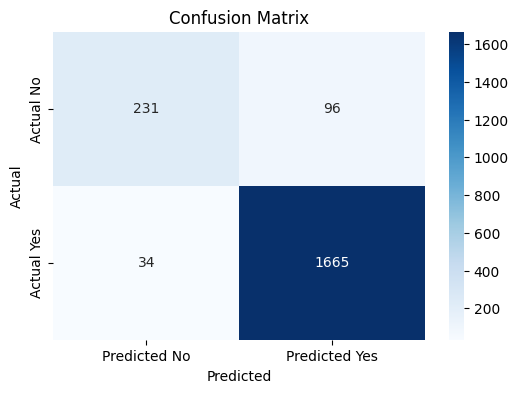

In [38]:
# Initialize the model
svc_model = SVC(random_state=42)

# Fit the model
svc_model.fit(X_train, y_train)

# Predict on the test set
y_pred = svc_model.predict(X_test)

# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted No', 'Predicted Yes'], yticklabels=['Actual No', 'Actual Yes'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [40]:
# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'C': np.logspace(-3, 3, 10),
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto'] + list(np.logspace(-3, 2, 6)),
    'degree': [2, 3, 4]  # Only relevant for poly kernel
}

# Initialize the SVM model
svc_model = SVC(random_state=42)

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(svc_model, param_distributions=param_dist, n_iter=20, cv=5, scoring='accuracy', random_state=42, n_jobs=-1, verbose=1)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Get the best parameters and accuracy
best_params = random_search.best_params_
best_score = random_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Accuracy: {best_score}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits


VYHODNOCENÍ